# Monte Carlo Learning

We implement an off-policy every-visit Monte Carlo Control and off-policy every-visit Monte Carlo Control with Weighted Importance Sampling. We will apply both of these algorithms on the **frozen lake** and **blackjack** environments and visualize their performance.

In [9]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import collections

from numpy import array
from random import uniform
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from gym.envs.toy_text.frozen_lake import FrozenLakeEnv
from gym.envs.toy_text.blackjack import BlackjackEnv

%matplotlib inline

plt.style.use('ggplot')

### Setup the Environment

Frozen lake is a grid world where the agent must reach a goal state while
avoiding holes. You can get the full description of frozen lake [here](https://gym.openai.com/envs/FrozenLake-v0/). The other environment is Blackjack game which is the same version of
blackjack described in Example 5.1 in [SB](http://incompleteideas.net/book/the-book-2nd.html). You can get the full description of blackjack [here](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py).

In [10]:
blackjack_env = BlackjackEnv()
frozen_lake_env = FrozenLakeEnv(desc=None, map_name="4x4",is_slippery=False)

### Step 1: Implement  $\epsilon$ -Greedy strategy
 
Implement $\epsilon$-greedy action selection based on the current Q-values. Break ties between equal Q-values uniformly randomly. Remeber an action should be a number in the range: [0, num_actions].

In [11]:
def eGreedyActionSelection(q_curr, eps):
    '''
    Preforms epsilon greedy action selectoin based on the Q-values.
    
    Args:
        q_curr: A numpy array that contains the Q-values for each action for a state.
        eps: The probability to select a random action. Float between 0 and 1.
        
    Returns:
        The selected action.
    '''
    number_of_actions = len(q_curr)
    
    # creating a probabilities for the policy
    probs = np.zeros(number_of_actions)
    probs.fill(eps/number_of_actions)
    
    # breaking ties uniformly randomly
    maxq = np.max(q_curr)
    best_action = np.random.choice(np.flatnonzero(q_curr == maxq))
    
    # set prob of greedy action
    probs[best_action] = 1 - eps  + (eps/number_of_actions)
    
    #select actions based on the probs for E-greedy policy
    action = np.random.choice(number_of_actions, p=probs)    

    return action

### Step 2: Implement the off-policy every-visit MC update

Implement the off-policy every-visit Monte Carlo update using the incremental update formula in Section 2.4 in SB. In MC we average the *returns*. In the formula below $G_n$ denotes the return at timestep $n$.

$$
\begin{align}
    Q_{n+1} = Q_n + \alpha [G_n - Q_n]
\end{align}
$$

In [12]:
def updateMCValues(Q_func, episode_transitions, gamma, alpha):
    '''
    Updates the Q-function according to the given episode transitions.
    
    Args:
        Q_func: A dictonary mapping state -> action values.
        episode_transitions: A list of (state, action, reward) tuples describing the episode.
        gamma: The discount factor.
        alpha: The stepsize.
        
    Returns:
        The updated Q-function.
    '''
    returns = defaultdict(float)
    
    # MC prediction - updates the Q values
    for i,(state,action,reward) in enumerate(episode_transitions):
        
        # sum up returns
        G = sum([seq[2] * gamma**j for j,seq in enumerate(episode_transitions[i:])])
        
        returns[(state,action)] += G
        
        # incremental update
        Q_func[state][action] = Q_func[state][action] + alpha * (returns[(state,action)] - Q_func[state][action])       

    return Q_func

### Step 3: Train the agent

Prints the state, action, next state, reward, done flag information to
the screen for each transition experienced. Set logging to True/False depending on your requirement.

In [13]:
def train_mc_agent(env, num_episodes, eps=0.1, gamma=1.0, alpha=0.1, logging=True):
    '''
    Trains a off-policy every-visit MC agent.
    
    Args:
        env: The environment to train the agent on.
        num_episodes: The number of episodes to train the agent for.
        eps: The probability to select a random action. Float between 0 and 1.      
        gamma: The discount factor.
        alpha: The stepsize.
        logging: Boolean flag which turns logging off/on.
        
    Returns:
        A tuple: (Q_func, episode_rewards)
        Q_func is a dictonary mapping state -> action values.
        episode_rewards is a list containing the rewards obtained for each episode during training.
    '''
    
    # a dictionary of what actions mean for each environment
    if isinstance(env,FrozenLakeEnv):
        actiondict = { 0:'LEFT',
                       1:'DOWN',
                       2:'RIGHT',
                       3:'UP'}
    elif isinstance(env, BlackjackEnv):
        actiondict = {0: 'STICK',
                     1: 'HIT'}
    
    # Create Q function dict with default values
    init_q_value = 0.0
    Q_func = defaultdict(lambda: np.ones(env.action_space.n) * init_q_value)
    
    episode_rewards = [0.0]
    pbar = tqdm.trange(num_episodes-1) if logging else range(num_episodes-1)
    for curr_episode in pbar: 
        episode_transitions = list()
        state = env.reset()
        is_done = False
        
        while not is_done:
            # Get the next action and execute it
            action = eGreedyActionSelection(Q_func[state], eps)
            new_state, reward, is_done, info = env.step(action)
            episode_transitions.append((state, action, reward))
            
            if logging:
                # **** YOUR CODE HERE to display E-GREEDY ACTION SELECTION ****
                # Display experienced obs, action, new_obs, rew, done tuples.
                print("state: {}, action: {}, next state: {}, reward: {}, done?: {}"
                      .format(state, actiondict[action], new_state, reward, is_done))
                pass

            state = copy.deepcopy(new_state)

        # Update the Q function
        Q_func = updateMCValues(Q_func, episode_transitions, gamma, alpha)
            
        # Bookkeeping: store episode rewards to measure performance.
        episode_rewards[-1] += reward
        episode_rewards.append(0.0)
        mean_100ep_reward = round(np.mean(episode_rewards[-51:-1]), 1)
        if logging:
            pbar.set_description('Mean Reward: {}'.format(mean_100ep_reward))
            
    return Q_func, episode_rewards

In [16]:
# Demonstrating how logging takes place (not actual training)

#Generating trasitions using minimal episodes:
print("Transitions for Frozen Lake environment:")
train_mc_agent(frozen_lake_env, 10)

print("Transitions for Black Jack environment:")
train_mc_agent(blackjack_env, 10)

Mean Reward: -1.0: 100%|██████████| 9/9 [00:00<00:00, 739.30it/s]

Transitions for Frozen Lake environment:
state: 0, action: DOWN, next state: 4, reward: 0.0, done?: False
state: 4, action: DOWN, next state: 8, reward: 0.0, done?: False
state: 8, action: UP, next state: 4, reward: 0.0, done?: False
state: 4, action: LEFT, next state: 4, reward: 0.0, done?: False
state: 4, action: UP, next state: 0, reward: 0.0, done?: False
state: 0, action: UP, next state: 0, reward: 0.0, done?: False
state: 0, action: UP, next state: 0, reward: 0.0, done?: False
state: 0, action: UP, next state: 0, reward: 0.0, done?: False
state: 0, action: UP, next state: 0, reward: 0.0, done?: False
state: 0, action: UP, next state: 0, reward: 0.0, done?: False
state: 0, action: RIGHT, next state: 1, reward: 0.0, done?: False
state: 1, action: LEFT, next state: 0, reward: 0.0, done?: False
state: 0, action: RIGHT, next state: 1, reward: 0.0, done?: False
state: 1, action: DOWN, next state: 5, reward: 0.0, done?: True
state: 0, action: UP, next state: 0, reward: 0.0, done?: False

(defaultdict(<function __main__.train_mc_agent.<locals>.<lambda>()>,
             {(13, 1, False): array([ 0. , -0.1]),
              (20, 1, False): array([ 0. , -0.1]),
              (16, 3, True): array([ 0. , -0.1]),
              (13, 3, False): array([ 0. , -0.1]),
              (16, 3, False): array([ 0. , -0.1]),
              (13, 10, False): array([-0.1,  0. ]),
              (10, 4, False): array([-0.1, -0.1]),
              (20, 4, False): array([ 0. , -0.1]),
              (15, 10, False): array([ 0. , -0.1]),
              (21, 10, False): array([ 0. , -0.1]),
              (19, 2, False): array([ 0. , -0.1]),
              (16, 10, False): array([ 0. , -0.1]),
              (20, 6, False): array([-0.1,  0. ])}),
 [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0])

### Step 4: Plot learning curve averaged over 50 runs

Calculate a learning curve averaged over 50 runs for step size parameter, α = 0.1. The learning curve plot is moving average of reward per episode as a function of episode number. 
The FrozenLake environment is trained for *50 runs with 5000 epsiodes per run*.
The BlackJack environment is trained for *50 runs with 50000 episodes per run*.

In [17]:
# helper functions
def plot_avg_reward(env_name, rewards):
    '''
    Plots the average reward over 50 runs
    
    Args:
        env_name: Name of the environment
        rewards: A list of list of rewards from 50 runs
    Effect:
        Displays a plot
    '''
    plt.figure(figsize=(12,10))
    plt.title("Rewards averaged over 50 runs for {}".format(env_name))
    plt.xlabel("Episode")
    plt.ylabel("Averaged Rewards")
    plt.plot(rewards, 'blue')
    plt.show()

    
def plot_moving_avg(env_name, rewards, window_size=100):
    '''
    Plots the moving average of rewards
    
    Args:
        env_name: Name of the environement
        rewards: A list of list of rewards from 50 runs
    Effect:
        Display a plot
    '''
    plt.figure(figsize=(12,10))
    plt.title("Moving Average of Rewards for {}".format(env_name))
    plt.xlabel("Episode")
    plt.ylabel("Average Rewards")
    
    # calculates moving average of rewards with window of 100 by default
    cumsum_reward = np.cumsum(rewards)
    move_avg_rewards = (cumsum_reward[window_size:] - cumsum_reward[:-window_size])/window_size

    plt.plot(move_avg_rewards, 'green')
    
    
def train_multiple_runs(env, learning_algo = train_mc_agent, runs=50, episodes=50000, logging=False):    
    '''
    Trains for multiple runs of the learning algo
    
    Args:
        env: environment on which we need to train the agent
        learning_algo: name of the learning algorithm used to trained 
                        (possible values: 'train_mc_agent' or 'train_mc_agent_importance_sampling')
        runs: number of runs to perform
        episodes: number of episodes to execute per run
    
    Returns:
        meanrewards: mean rewards over given number of runs for given number of episodes
    '''
    rewards = []
    
    # perform multiple runs of the given learning algorithm
    for x in range(runs):
        q_func, reward = learning_algo(env, episodes,logging=logging)
        rewards.append(reward)
            
    # calculate mean reward over 50 runs of the simulation
    meanrewards = np.mean(rewards, axis=0)
    return meanrewards

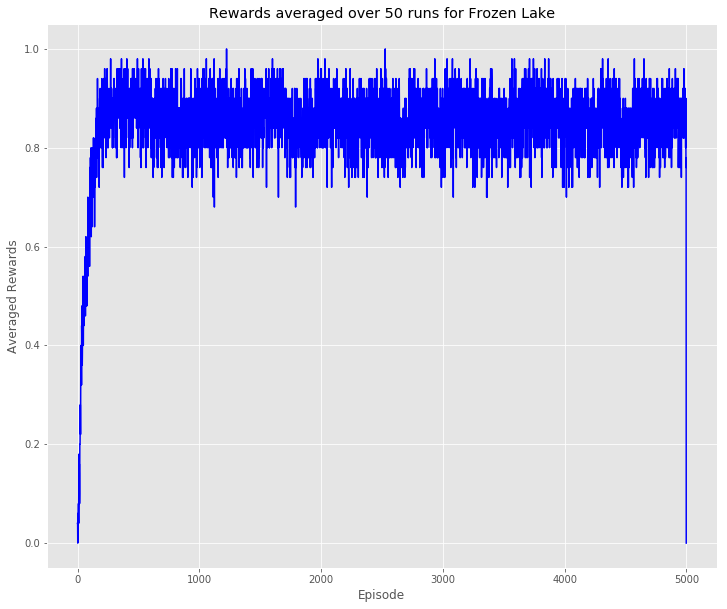

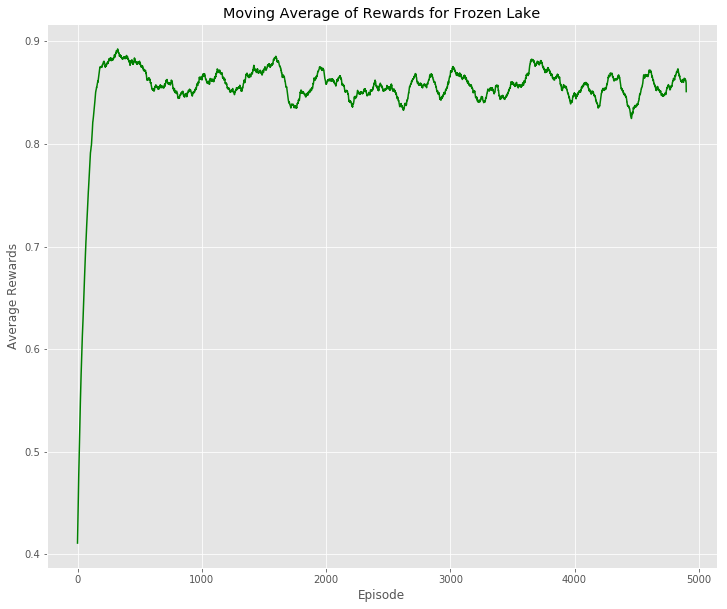

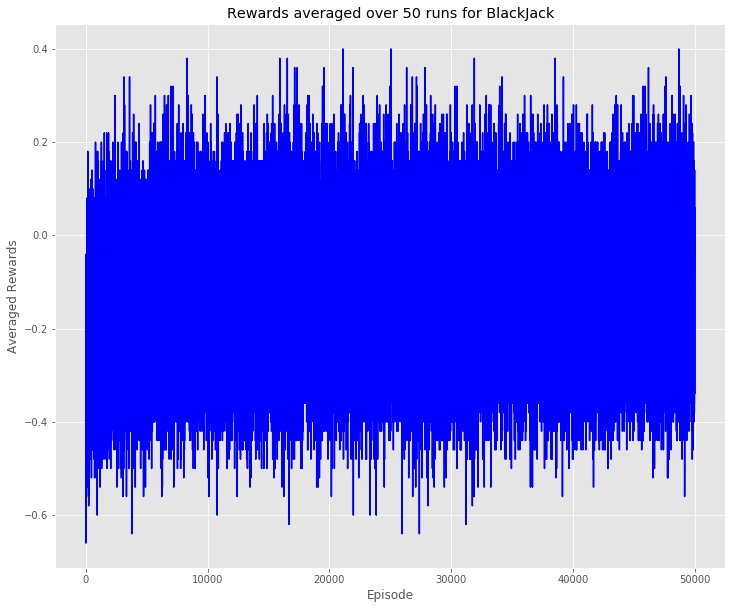

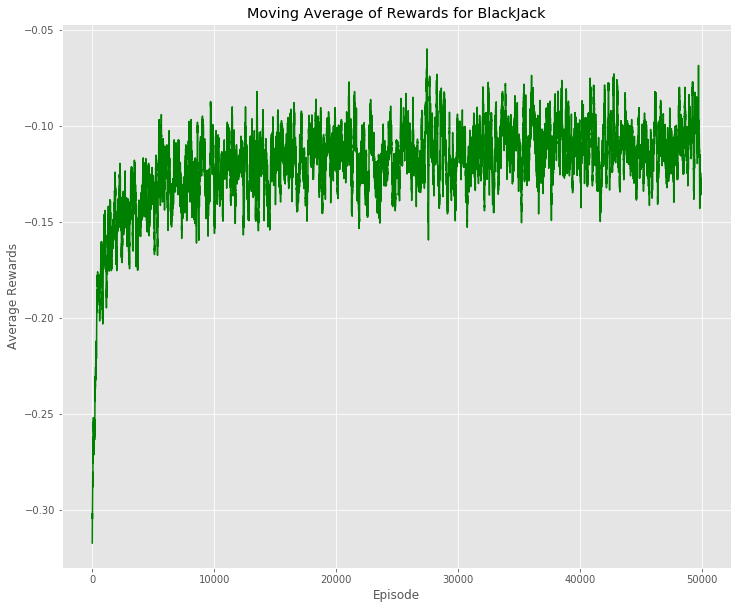

In [18]:
# train frozen lake for 50 runs of 5000 episodes
mean_rewards_frozen_lake = train_multiple_runs(frozen_lake_env, train_mc_agent,50, 5000)
# train blackjack for 50 runs of 50000 episodes
mean_rewards_blackjack = train_multiple_runs(blackjack_env, train_mc_agent, 50, 50000)

# environment names
frozen_lake_env_name = "Frozen Lake"
blackjack_env_name = "BlackJack"

# plot mean rewards for frozen lake over 50 runs
plot_avg_reward(frozen_lake_env_name, mean_rewards_frozen_lake)

# plot moving average of rewards for frozen lake
plot_moving_avg(frozen_lake_env_name, mean_rewards_frozen_lake)

# plot mean rewards for black jack over 50 runs
plot_avg_reward(blackjack_env_name, mean_rewards_blackjack)

# plot moving average of rewards for blackjack
plot_moving_avg(blackjack_env_name, mean_rewards_blackjack)

### Step 5: Plot the value and policy for BlackJack similar to plots in Sutton-Barto

Train the agent for 500k episodes for the blackjack environment with a step size parameter that enables the value function to converge. Plot the value 'function as a color plot with a similar layout to that shown in SB Figure 5.1. Also plot the learned blackjack policy, showing something similar to that shown in SB Figure 5.2.

In [57]:
# helper functions
def get_policy(Q):
    '''
    Gets the policy based on given Q values
    
    Args:
        Q: Q state-action values
        
    Returns:
        policy: represents a policy which is based on given Q values
    '''
    policy = defaultdict(float)
    
    for state in Q.keys():
        if state[0] > 11:
            policy[state] = np.argmax(Q[state])
    
    return policy


def get_values(Q):
    '''
    Gets the value function for the given Q values
    
    Args:
        Q: Q state-action values
        
    Returns:
        V: represents the state-value function for the given Q values
    '''
    V = defaultdict(float)
    
    for state, action_val in Q.items():
        if state[0] > 11:
            max_action_val = np.max(action_val)
            V[state] = max_action_val
    
    return V


def surface_plot(X,Y,Z, plot_name):
    '''
    Plots the values of the Blackjack playing agent
    Args:
        X: Player sum values
        Y: Dealer show values
        Z: Values to plot
    Effect:
        Plots the Values
    '''
    fig = plt.figure(figsize = (15,10))
    ax = fig.gca(projection='3d')
    surf1 = ax.plot_surface(X,Y,Z, cmap=cm.seismic, vmin=-1.0, vmax=1.0)
    fig.colorbar(surf1)
    ax = fig.gca(projection='3d')
    ax.view_init(ax.elev, -120)
    ax.set_title(plot_name)
    ax.set_xlabel("Player Sum")
    ax.set_ylabel("Dealer Show")
    plt.xticks(np.arange(12, 22, step=1))
    plt.yticks(np.arange(1,11, step=1))
    
    
def draw_value_plots(Q):
    '''
    Plots the state-values for the given Q values
    
    Args:
        Q: Q state-action values
        
    Effect:
        Plots two surface graphs(representing state values) one with usable aces and another without ace
    '''
    
    # making data    
    X,Y = np.meshgrid(np.arange(12,22) , np.arange(1,11))
    
    #gets state-values from action values
    V = get_values(Q)
    
    #states based on first two values in state tuple
    states = zip(X.flatten(), Y.flatten())
    
    # values without the aces
    values_without_aces = [V[x,y,False] for x,y in states]
    Z_no_aces = np.array(values_without_aces).reshape(Y.shape)
    
    #states based on first two values in state tuple
    states = zip(X.flatten(), Y.flatten())
    
    # values with the aces
    values_with_aces = [V[x,y,True] for x,y in states]
    Z_aces = np.array(values_with_aces).reshape(Y.shape)
    
    # plots the values with and without ace
    surface_plot(X,Y,Z_no_aces, "No Usable Ace")
    surface_plot(X,Y,Z_aces, "Usable Ace")

    
def plot_policy(policy, ace, ax, plot_name, policy_fig):
    '''
    Plots the give policy
    
    Args:
        policy: represents a policy to be plotted
        ace: a boolean representing if the plot is for usable or no usable ace
        ax: Axes3D object
        plot_name: title of the plot
        
    Effect:
        plots the given policy
    '''
    
    # player_sum and deal_show range
    x = np.arange(12,22)
    y = np.arange(1,11)
    
    # get policy values for all player_sums and dealer_shows
    Z = np.array([[policy[(plyr_sum, dealer_show, ace)] for dealer_show in y] for plyr_sum in reversed(x)])

    #fit the plot perfectly
    fitting = [0.5, 10.5, 10.5, 21.5]
    
    # plot the intensity graph
    plots = ax.imshow(Z, cmap = 'Paired', extent=fitting)
    
    #define x and y axis intervals
    plt.xticks(y)
    plt.yticks(x)
    
    ax.set_title(plot_name)
    ax.set_ylabel("Player Sum")
    ax.set_xlabel("Dealer Show")
    
        
def draw_policy_plots(Q):
    '''
    Plots the two graphs for policy with or without aces
    
    Args:
        Q: Q state-action values
    
    Effects:
        Plots two policy graphs one with usable aces and another without ace
    '''
    policy_fig = plt.figure(figsize=(15,10))
    policy = get_policy(Q)

    ax = policy_fig.add_subplot(121)
    plot_policy(policy, True, ax, "Usable Ace", policy_fig)
    
    ax = policy_fig.add_subplot(122)
    plot_policy(policy, False, ax, "No Usable Ace", policy_fig)
 

In [36]:
# implementing step 5
# trains the agent with small alpha for better convergence
Q, rewards = train_mc_agent(blackjack_env, 2000000, alpha=0.01, logging=False)

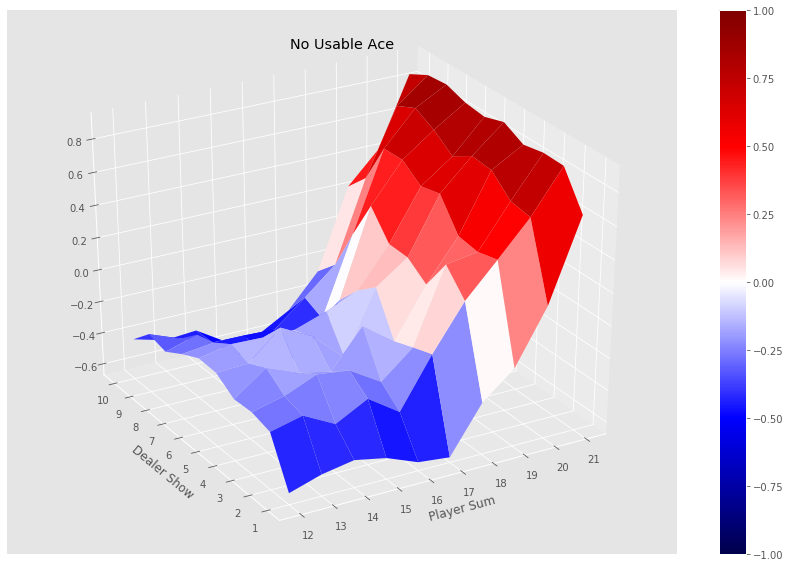

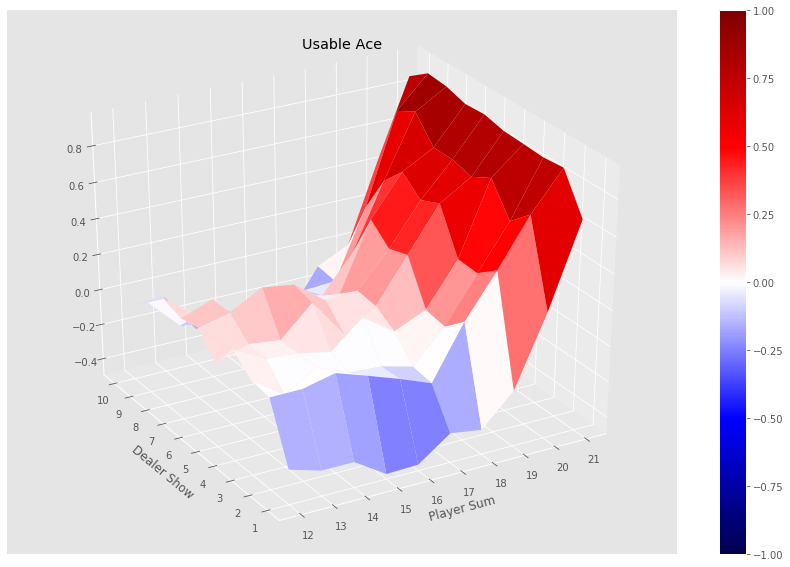

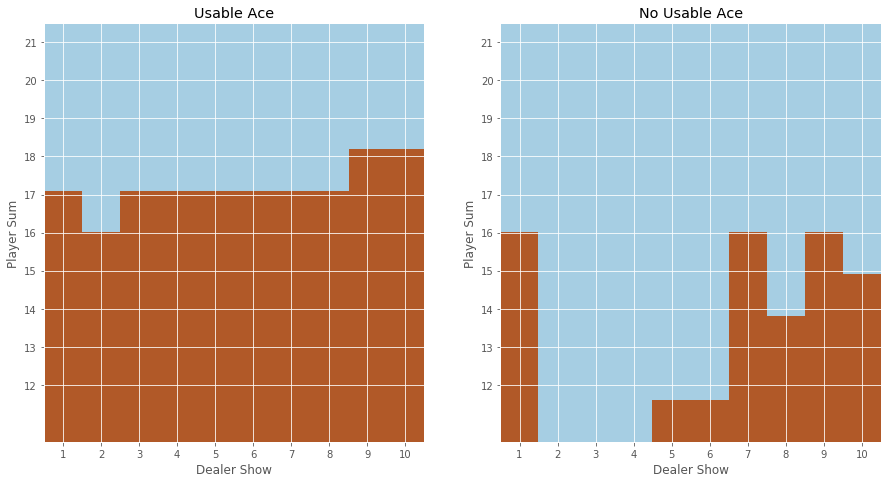

In [58]:
# plots 3D surface plots of state-values
draw_value_plots(Q)

# plots the learned policies
# policy plotted from player_sum 12 to 21 to be consistent with the value surface plot
#cyan - STICK
#brown - HIT
draw_policy_plots(Q)

### Step 6: Implement off-policy every-visit MC with Importance Sampling

Implement the below function to train a off-policy every-visit MC agent which uses weighted importance sampling.

In [38]:
# Behavior policy is E-greedy policy, it is implemented inside the random_policy function

def updateMCImpSamplingValues(Q_func, episode_transitions, gamma, alpha, C, eps):
    '''
    Updates the Q-function according to the given episode transitions.
    
    Args:
        Q_func: A dictonary mapping state -> action values.
        episode_transitions: A list of (state, action, reward) tuples describing the episode.
        gamma: The discount factor.
        alpha: The stepsize.
        C: cumalative sum at a state
        eps: Epsilon value
        
    Returns:
        The updated Q-function.
    '''
    #return
    G = 0.0
    
    #weight
    W = 1.0
        
    # MC prediction with importance sampling
    for (state,action,reward) in reversed(episode_transitions):
        #calculate return
        G = reward + G * gamma
        
        C[(state,action)] = C[(state,action)] + W
        
        # update step using importance sampling
        Q_func[state][action] = Q_func[state][action] + ((W / C[(state,action)]) * (G - Q_func[state][action]))
        
        # probabilites for actions according to the behavior policy(E-greeedy)
        random_prob = random_policy(Q_func[state], eps)
        
        #probabilites for actions according to the target policy
        target_action_probs = target_policy(Q_func[state])
        #picking the target action based on above probs
        target_action = np.random.choice(np.arange(len(Q_func[state])), p=target_action_probs)
        
        if not action == target_action:
            break
    
        # use 1.0 as the probability for target_action being the current action because if the target_action
        # would have being different then we would have broken out of the loop early on
        # probs of target_policy can be either 0/1
        W = W * (1.0 / random_prob[action])
        
    return Q_func


# Behavior policy which is basically E-greedy policy
# This is the policy based on which we act (behavior policy)
def random_policy(q_curr, eps):
    number_of_actions = len(q_curr)
    
    # create probabilites for e-greedy policy
    e_greedy_probs = np.zeros(number_of_actions)
    e_greedy_probs.fill(eps/number_of_actions)
    
    #greedy_action (with ties broken uniformly randomly)
    maxq = np.max(q_curr)
    greedy_action = np.random.choice(np.flatnonzero(q_curr == maxq))
    
    # set prob of the greedy action probability to high
    e_greedy_probs[greedy_action] = 1 - eps + (eps / number_of_actions)
    
    return e_greedy_probs


# Deterministic target policy which is our near-optimal policy 
def target_policy(q_curr):
    maxq = np.max(q_curr)
    best_action = np.random.choice(np.flatnonzero(q_curr == maxq))
    target_policy_probs = np.zeros(len(q_curr))
    target_policy_probs[best_action] = 1.0
    return target_policy_probs
    
    
def train_mc_agent_importance_sampling(env, num_episodes, eps=0.1, gamma=1.0, alpha=0.1, logging=True):
    '''
    Trains a off-policy every-visit MC agent with weighted importance sampling.
    
    Args:
        env: The environment to train the agent on.
        num_episodes: The number of episodes to train the agent for.
        eps: The probability to select a random action. Float between 0 and 1.      
        gamma: The discount factor.
        alpha: The stepsize.
        logging: Boolean flag which turns logging off/on.
        
    Returns:
        A tuple: (Q_func, episode_rewards)
        Q_func is a dictonary mapping state -> action values.
        episode_rewards is a list containing the rewards obtained for each episode during training.
    '''
    
    if isinstance(env,FrozenLakeEnv):
        actiondict = { 0:'LEFT',
                       1:'DOWN',
                       2:'RIGHT',
                       3:'UP'}
    elif isinstance(env, BlackjackEnv):
        actiondict = {0: 'STICK',
                     1: 'HIT'}
        
    init_q_value = 0.0
    Q_func = defaultdict(lambda: np.ones(env.action_space.n) * init_q_value)
    C = defaultdict(float)
    
    # Your implementation here!    
    episode_rewards = [0.0]
    pbar = tqdm.trange(num_episodes-1) if logging else range(num_episodes-1)
    
    for curr_episode in pbar: 
        episode_transitions = list()
        state = env.reset()
        is_done = False
        
        while not is_done:
            # Get the next action and execute it
            e_greedy_probs = random_policy(Q_func[state], eps)
            action = np.random.choice(np.arange(len(Q_func[state])), p=e_greedy_probs)
            new_state, reward, is_done, game_info = env.step(action)
            episode_transitions.append((state, action, reward))
            
            if logging:
                # **** YOUR CODE HERE to display E-GREEDY ACTION SELECTION ****
                # Display experienced obs, action, new_obs, rew, done tuples.
                print("state: {}, action: {}, next state: {}, reward: {}, done: {}"
                      .format(state, actiondict[action], new_state, reward, is_done))
                pass

            state = copy.deepcopy(new_state)

        # Update the Q function
        Q_func = updateMCImpSamplingValues(Q_func, episode_transitions, gamma, alpha, C, eps)
    
    
    # Bookkeeping: store episode rewards to measure performance.
        episode_rewards[-1] += reward
        episode_rewards.append(0.0)
        mean_100ep_reward = round(np.mean(episode_rewards[-51:-1]), 1)
        if logging:
            pbar.set_description('Mean Reward: {}'.format(mean_100ep_reward))
        
    return Q_func, episode_rewards


### Step 7: Train and plot value function and policy for Importance Sampling

Repeat Steps 4 & 5 using the new MC agent which uses weighted importance sampling. Compare the results.

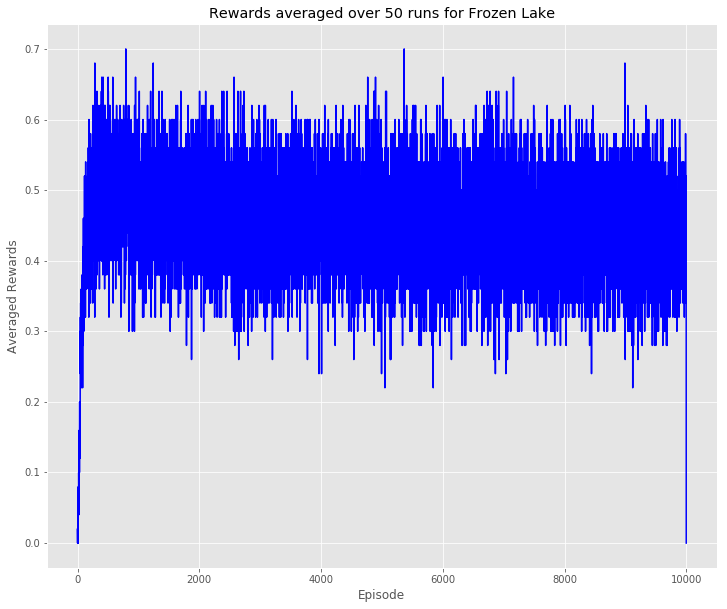

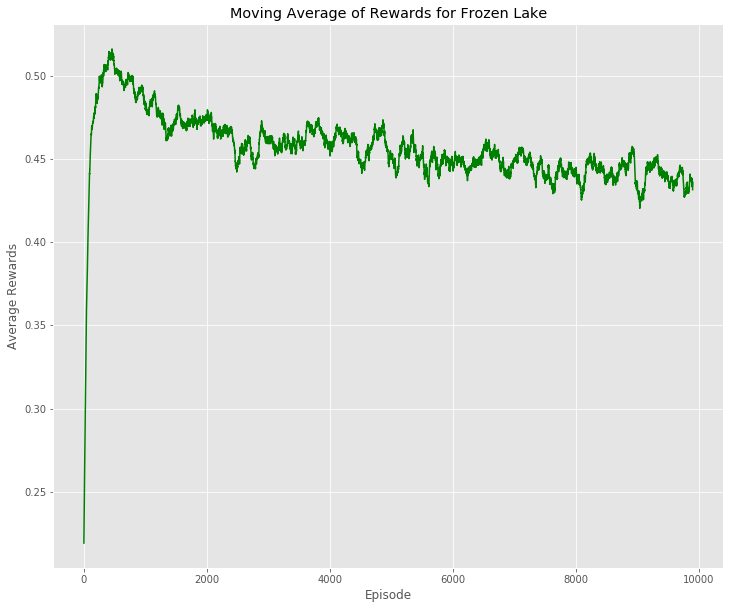

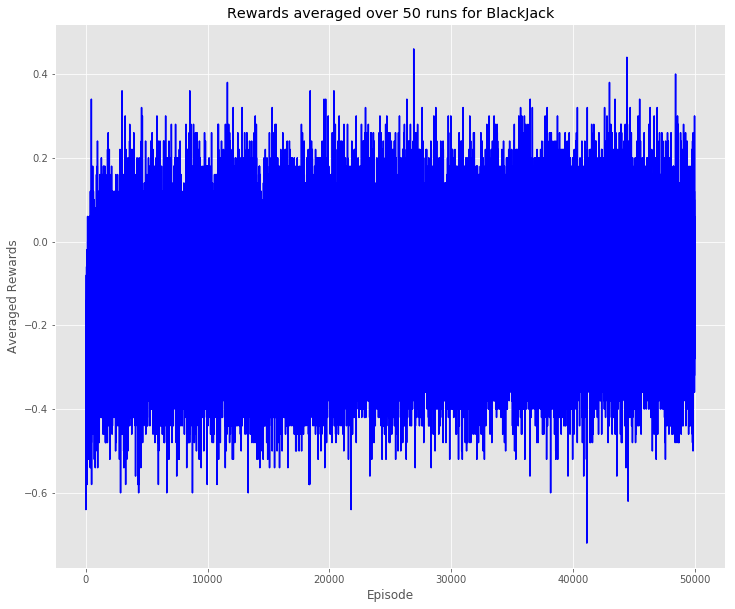

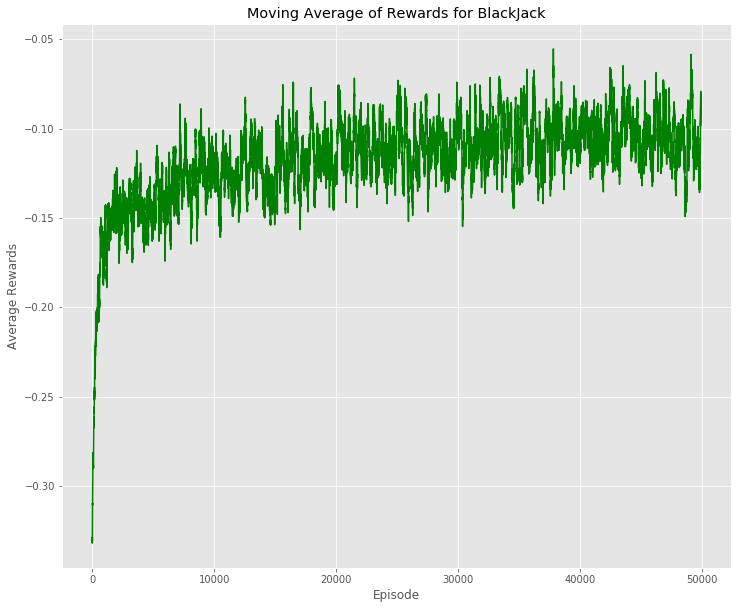

In [40]:
# train new MC agent on FrozenLake for 50 runs of 10000 episodes
mean_rewards_frozen_lake_imp_sampl = train_multiple_runs(frozen_lake_env, train_mc_agent_importance_sampling, runs=50, episodes=10000)
# train new MC agent on BlackJack for 50 runs of 50000 episodes
mean_rewards_blackjack_imp_sampl = train_multiple_runs(blackjack_env, train_mc_agent_importance_sampling, runs=50, episodes=50000)

# environment names
frozen_lake_env_name = "Frozen Lake"
blackjack_env_name = "BlackJack"

#plot mean rewards averaged over 50 runs
plot_avg_reward(frozen_lake_env_name, mean_rewards_frozen_lake_imp_sampl)

#plot moving average of rewards
plot_moving_avg(frozen_lake_env_name, mean_rewards_frozen_lake_imp_sampl)

#plot mean rewards averaged over 50 runs
plot_avg_reward(blackjack_env_name, mean_rewards_blackjack_imp_sampl)

#plot moving average of rewards
plot_moving_avg(blackjack_env_name, mean_rewards_blackjack_imp_sampl)

In [41]:
# Step 5 for new MC agent
# train the agent on BlackJack env for 1500000 episodes
Q_imp_sampling, rewards = train_mc_agent_importance_sampling(blackjack_env, 2000000, logging=False)

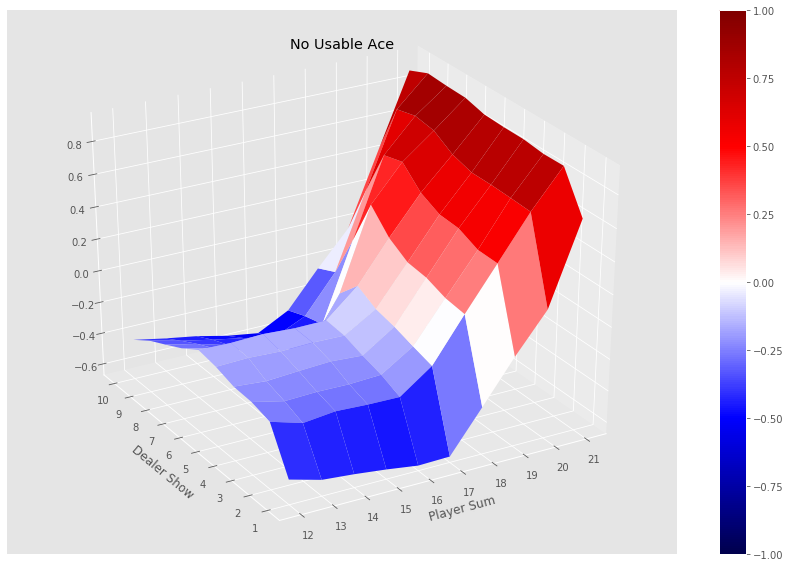

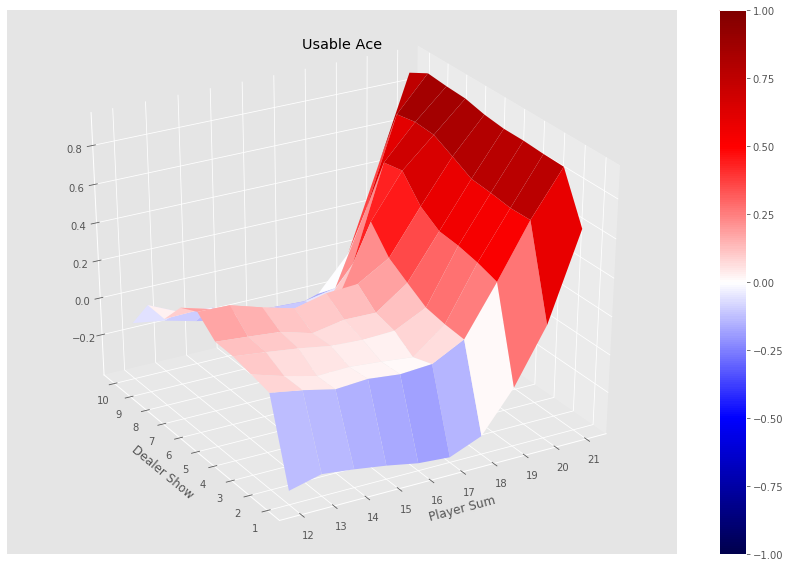

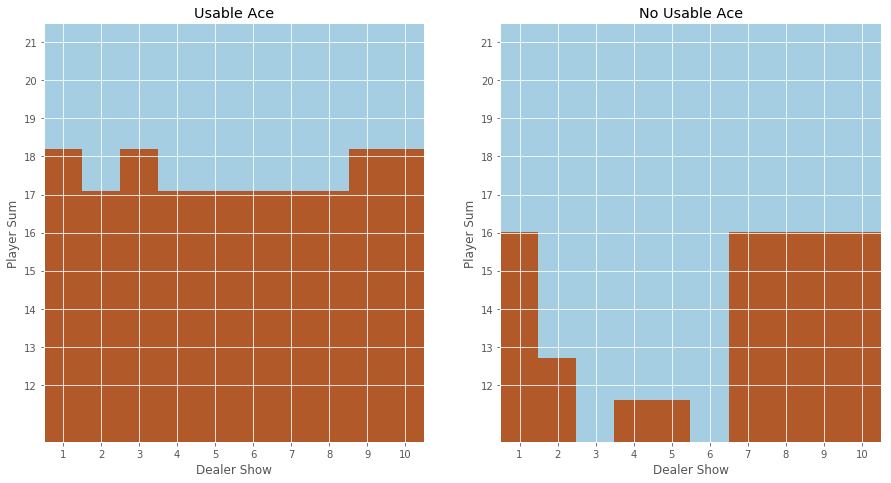

In [42]:
# plot state values
draw_value_plots(Q_imp_sampling)

# plot the policy
# policy plotted from player_sum 12 to 21 to be consistent with the value surface plot
# cyan - STICK
# brown -HIT
draw_policy_plots(Q_imp_sampling)

##### References:
1. Richard S., Andrew B. (2018). Reinforcement Learning: An Introduction (Book)
2. Holly Grimm. (2018) Reinforcement Learning - Monte Carlo Methods and OpenAI Gym's Blackjack.
    https://hollygrimm.com/rl_mc